# Import DataSet

In [55]:
import numpy as np
import util_mnist_reader
from sklearn.cluster import KMeans

X_train, y_train = util_mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = util_mnist_reader.load_mnist('data/fashion', kind='t10k')

#x = np.concatenate((X_train, X_test))
#y = np.concatenate((y_train, y_test))
#x = x.reshape((x.shape[0], -1))
X_train = np.divide(X_train, 255.)
X_test = np.divide(X_test, 255.)

# Kmeans

In [56]:
kmeans = KMeans(n_clusters = 10, random_state = 0, n_init = 20, max_iter = 300, copy_x = True, algorithm = 'auto', n_jobs = -1)

#kmeans.labels_
#kmeans.cluster_centers_
kmeans.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=20, n_jobs=-1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

# Label Mapping for clusters and original labels

In [57]:
from scipy.stats import mode

def map_labels(y_pred):
    labels = np.zeros_like(y_pred)
    
    for i in range(10):
      mask = (y_pred == i)
      labels[mask] = mode(y_test[mask])[0]

    return labels

In [81]:
y_pred_kmeans = kmeans.predict(X_test)
predicted_labels = map_labels(y_pred_kmeans)
print('Accuracy for KMeans clustering: ',np.mean(y_test == predicted_labels))

Accuracy for KMeans clustering:  0.5599


In [59]:
from sklearn.metrics import normalized_mutual_info_score, homogeneity_completeness_v_measure

normalized_mutual_info_score(y_test, y_pred_kmeans)

0.5126706355801629

In [60]:
homogeneity_completeness_v_measure(y_test, y_pred_kmeans)

(0.5009655407934087, 0.524649220722661, 0.51253392686675)

Confusion Matrix for KMeans clustering:


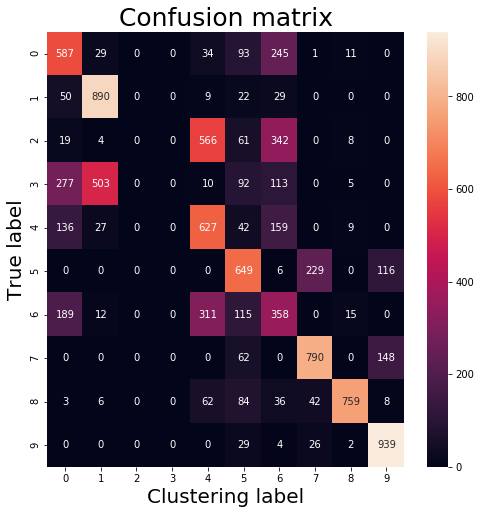

In [100]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

target_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

cm = confusion_matrix(y_test, predicted_labels)

print('Confusion Matrix for KMeans clustering:')
#print(cm)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix", fontsize=25)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Clustering label', fontsize=20)
plt.show()

In [62]:
print(classification_report(y_test, predicted_labels, target_names = target_names))

             precision    recall  f1-score   support

T-shirt/top       0.47      0.59      0.52      1000
    Trouser       0.61      0.89      0.72      1000
   Pullover       0.00      0.00      0.00      1000
      Dress       0.00      0.00      0.00      1000
       Coat       0.39      0.63      0.48      1000
     Sandal       0.52      0.65      0.58      1000
      Shirt       0.28      0.36      0.31      1000
    Sneaker       0.73      0.79      0.76      1000
        Bag       0.94      0.76      0.84      1000
 Ankle Boot       0.78      0.94      0.85      1000

avg / total       0.47      0.56      0.51     10000



C:\Users\sneha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# AutoEncoder

In [63]:
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization

# Reshape the images
X_train1 = X_train.reshape(-1, 28, 28, 1)
X_test1 = X_test.reshape(-1,28,28,1)

input_img = Input(shape = (28, 28, 1))

def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(4, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 4
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(4, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 8
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 16
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [64]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = 'RMSprop', metrics = ['accuracy'])
autoencoder.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_31 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_32 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 14, 14, 64)        1849

In [103]:
from contextlib import redirect_stdout

with open('modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        autoencoder.summary()

In [65]:
history = autoencoder.fit(X_train1, X_train1, batch_size = 128, epochs = 10, verbose = 1, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 548s 10ms/step - loss: 0.0247 - accuracy: 0.5045 - val_loss: 0.0175 - val_accuracy: 0.5027
Epoch 2/10
54000/54000 [==============================] - 542s 10ms/step - loss: 0.0125 - accuracy: 0.5088 - val_loss: 0.0139 - val_accuracy: 0.5045
Epoch 3/10
54000/54000 [==============================] - 453s 8ms/step - loss: 0.0099 - accuracy: 0.5094 - val_loss: 0.0136 - val_accuracy: 0.5048
Epoch 4/10
54000/54000 [==============================] - 393s 7ms/step - loss: 0.0084 - accuracy: 0.5097 - val_loss: 0.0093 - val_accuracy: 0.5057
Epoch 5/10
54000/54000 [==============================] - 413s 8ms/step - loss: 0.0077 - accuracy: 0.5098 - val_loss: 0.0067 - val_accuracy: 0.5060
Epoch 6/10
54000/54000 [==============================] - 420s 8ms/step - loss: 0.0069 - accuracy: 0.5100 - val_loss: 0.0072 - val_accuracy: 0.5059
Epoch 7/10
54000/54000 [==============================] - 510

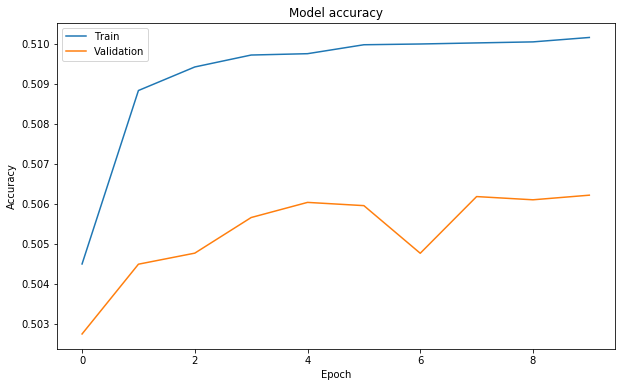

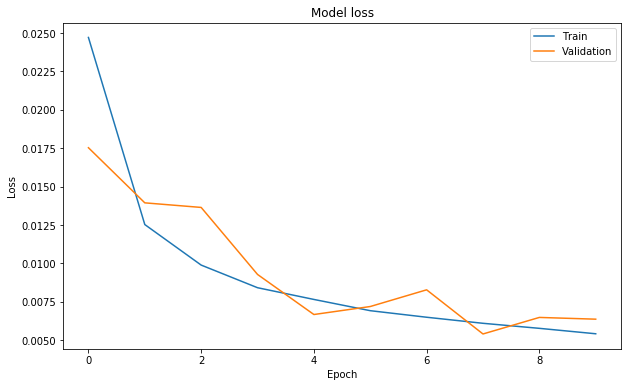

In [66]:
#Plot training & validation accuracy values
plt.figure(1, figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.savefig("AEAccuracy.png")
plt.show()

#Plot training & validation loss values
plt.figure(2, figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.savefig("AETraining_Loss.png")
plt.show()

In [67]:
restored_testing_dataset = autoencoder.predict(X_test1)

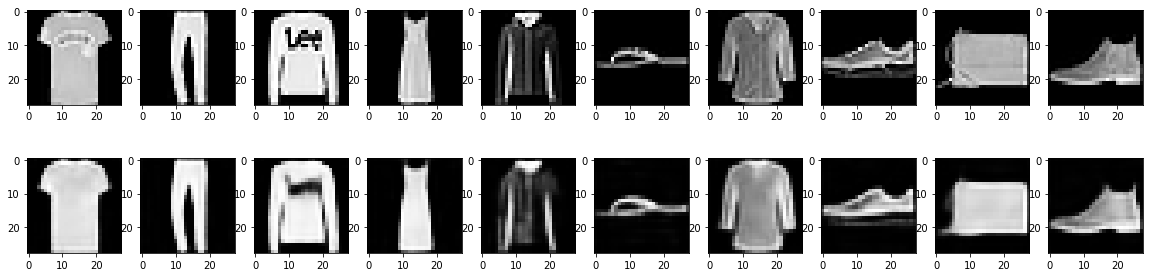

In [68]:
plt.figure(figsize=(20,5))
for i in range(10):
    index = y_test.tolist().index(i)
    plt.subplot(2, 10, i+1)
    plt.imshow(X_test1[index].reshape((28,28)))
    plt.gray()
    plt.subplot(2, 10, i+11)
    plt.imshow(restored_testing_dataset[index].reshape((28,28)))
    plt.gray()

In [69]:
autoencoder.save_weights('autoencoder.h5')

encode = Model(input_img,encoder(input_img))

for l1,l2 in zip(encode.layers[:19], autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())
encode.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_45 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_46 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 14, 14, 64)        1849

In [70]:
encoded_train = encode.predict(X_train1).reshape(-1, 4 * 7 * 7)
encoded_test = encode.predict(X_test1).reshape(-1, 4 * 7 * 7)

# Auto-Encoder with K-Means Clustering

In [71]:
kmeans1 = KMeans(n_clusters = 10, random_state = 0, n_init = 20, max_iter = 300, copy_x = True, algorithm = 'auto', n_jobs = -1)
kmeans1.fit(encoded_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=20, n_jobs=-1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [83]:
y_pred_ae = kmeans1.predict(encoded_test)
predicted_labels_ae = map_labels(y_pred_ae)
print('Accuracy for Auto-Encoder with KMeans clustering: ',np.mean(y_test == predicted_labels_ae))

Accuracy for Auto-Encoder with KMeans clustering:  0.5614


In [73]:
normalized_mutual_info_score(y_test, y_pred_ae)

0.5257080387068528

In [77]:
homogeneity_completeness_v_measure(y_test, y_pred_ae)

(0.5064119279216813, 0.5457394005216784, 0.5253406700914193)

Confusion Matrix for Auto-Encoder with KMeans clustering:


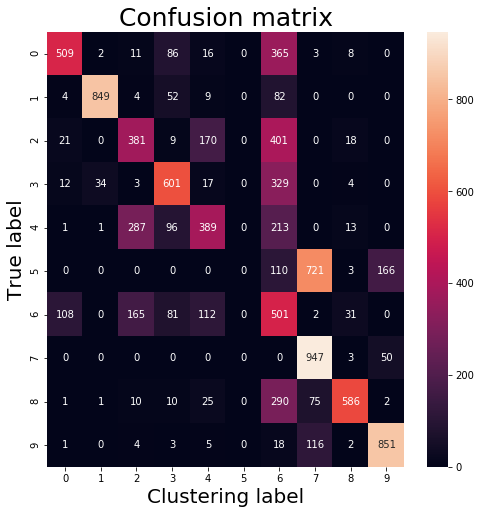

In [101]:
cm = confusion_matrix(y_test, predicted_labels_ae)

print('Confusion Matrix for Auto-Encoder with KMeans clustering:')
#print(cm)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix", fontsize=25)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Clustering label', fontsize=20)
plt.show()

In [89]:
print(classification_report(y_test, predicted_labels_ae, target_names = target_names))

             precision    recall  f1-score   support

T-shirt/top       0.77      0.51      0.61      1000
    Trouser       0.96      0.85      0.90      1000
   Pullover       0.44      0.38      0.41      1000
      Dress       0.64      0.60      0.62      1000
       Coat       0.52      0.39      0.45      1000
     Sandal       0.00      0.00      0.00      1000
      Shirt       0.22      0.50      0.30      1000
    Sneaker       0.51      0.95      0.66      1000
        Bag       0.88      0.59      0.70      1000
 Ankle Boot       0.80      0.85      0.82      1000

avg / total       0.57      0.56      0.55     10000



C:\Users\sneha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Auto-Encoder with GMM Clustering

In [74]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components = 10, covariance_type = 'full', n_init = 2, max_iter = 100, verbose = 1)

gmm.fit(encoded_train)

Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
Initialization converged: True
Initialization 1
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
Initialization converged: True


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=10, n_init=2, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=1,
        verbose_interval=10, warm_start=False, weights_init=None)

In [87]:
y_pred_gmm = gmm.predict(encoded_test)
predicted_labels_gmm = map_labels(y_pred_gmm)
print('Accuracy for Auto-Encoder with GMM clustering: ',np.mean(y_test == predicted_labels_gmm))

Accuracy for Auto-Encoder with GMM clustering:  0.6166


In [76]:
normalized_mutual_info_score(y_test, y_pred_gmm)

0.5932476673653505

In [78]:
homogeneity_completeness_v_measure(y_test, y_pred_gmm)

(0.5886447640799952, 0.5978865630181697, 0.5932296717275168)

Confusion Matrix for Auto-Encoder with GMM clustering:


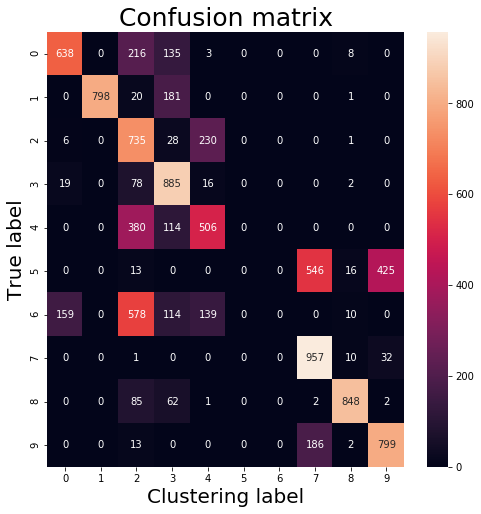

In [102]:
cm = confusion_matrix(y_test, predicted_labels_gmm)

print('Confusion Matrix for Auto-Encoder with GMM clustering:')
#print(cm)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix", fontsize=25)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Clustering label', fontsize=20)
plt.show()

In [90]:
print(classification_report(y_test, predicted_labels_gmm, target_names = target_names))

             precision    recall  f1-score   support

T-shirt/top       0.78      0.64      0.70      1000
    Trouser       1.00      0.80      0.89      1000
   Pullover       0.35      0.73      0.47      1000
      Dress       0.58      0.89      0.70      1000
       Coat       0.57      0.51      0.53      1000
     Sandal       0.00      0.00      0.00      1000
      Shirt       0.00      0.00      0.00      1000
    Sneaker       0.57      0.96      0.71      1000
        Bag       0.94      0.85      0.89      1000
 Ankle Boot       0.64      0.80      0.71      1000

avg / total       0.54      0.62      0.56     10000



C:\Users\sneha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
